In [17]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Proprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# XGBoost Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import optuna

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# For reproducibility
from teachopencadd.utils import seed_everything
SEED = 42
seed_everything(SEED)

In [18]:
train_file_path_UMAP = '../Data/Data/train_filter_UMAP.csv'
train_df_UMAP = pd.read_csv(train_file_path_UMAP)

# Pipelines

In [19]:
ode_cols = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
ohe_cols = ['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']
num_cols = train_df_UMAP.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop("SalePrice")

In [20]:
# from the sklearn.pipeline module
# assembles several steps that can be cross-validated together while setting different parameters.
# steps parameter is a list of tuples where each tuple represents a step in the pipeline

#impute is the name of the step
### SimpleImputer is a method from sklearn.impute module, fills in missing values in dataset
### strategy='mean' is the parameter, missing value replaceded by the mean value of corresponding feature

### scaler is the name of the next step
### StandardScaler is a method from sklearn.preprocessing module
### It standardizes features by removing the mean and scaling to unit variance
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#impute is the name of the step
### SimpleImputer is a method from sklearn.impute module, fills in missing values in dataset
### strategy='most frequent' is the parameter, missing value replaceded by the most frequent value of corresponding feature

### ohe is the name of the next step
### OneHotEncoder is a method from sklearn.preprocessing module and encodes categorical features as a one-hot numeric array
### handle_unknown='ignore' is the parameter, unknown categories are ignored
### sparse_output=False is a parameter, returns a dense array instead of a sparse matrix
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### ode is the name of the step
### OrdinalEncoder is a method from sklearn.preprocessing module and encodes categorical features as an ordinal numeric array
### handle_unknown='use_encoded_value' is the parameter, unknown categories are encoded with a user-specified value
### where the value is -1, set by unknown_value=-1
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

])

### ColumnTransformer is a method from sklearn.compose module
### Used to apply preprocessing pipelines to subsets of features in a dataset
### 'num_p', 'ode_p', 'ohe_p' are the names of the transformers
### num_pipeline, ode_pipeline, ohe_pipeline are the pipelines
### num_cols, ode_cols, ohe_cols are the columns to apply the pipelines to

### remaining columns should be passed through without any changes
# n_jobs=-1 uses all processors available
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough',
    n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [21]:
X = train_df_UMAP.drop('SalePrice', axis=1)
Y = train_df_UMAP['SalePrice']

# Pass the data through the pipeline
X_preprocessed = pipeline.fit_transform(X)

# Train test split
x_train_UMAP, x_test_UMAP, y_train_UMAP, y_test_UMAP = train_test_split(X_preprocessed, Y, test_size=0.2, random_state=SEED)

# Optuna: Define Objective function

In [22]:
def objective_UMAP(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 750)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-2, 0.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    gamma = trial.suggest_discrete_uniform('gamma', 0, 0.5, 0.1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1)

    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, random_state=SEED)
    model.fit(x_train_UMAP, y_train_UMAP)

    score = cross_val_score(model, x_train_UMAP, y_train_UMAP, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score



# XGB Regressor

{'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.05503466451418128,
 'min_child_weight': 5,
 'gamma': 0.4,
 'subsample': 0.5,
 'colsample_bytree': 0.6}

In [23]:
best_params_UMAP = {'n_estimators': 235,
 'max_depth': 5,
 'learning_rate': 0.06315273144693412,
 'min_child_weight': 1,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8}
best_n_estimators_UMAP = best_params_UMAP['n_estimators']
best_max_depth_UMAP = best_params_UMAP['max_depth']
best_learning_rate_UMAP = best_params_UMAP['learning_rate']
best_min_child_weight_UMAP = best_params_UMAP['min_child_weight']
best_gamma_UMAP = best_params_UMAP['gamma']
best_subsample_UMAP = best_params_UMAP['subsample']
best_colsample_bytree_UMAP = best_params_UMAP['colsample_bytree']

best_XGB_UMAP = XGBRegressor(n_estimators=best_n_estimators_UMAP, max_depth=best_max_depth_UMAP, learning_rate=best_learning_rate_UMAP, min_child_weight=best_min_child_weight_UMAP, gamma=best_gamma_UMAP, subsample=best_subsample_UMAP, colsample_bytree=best_colsample_bytree_UMAP, random_state=SEED)
best_XGB_UMAP.fit(x_train_UMAP, y_train_UMAP)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06315273144693412,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=235, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Gradient Boosting Regressor

In [24]:
# best_params_UMAP = study_UMAP_GBR.best_params
best_params_GBR = {'n_estimators': 689,
 'max_depth': 5,
 'max_features': 0.19742817054348497,
 'min_samples_leaf': 1,
 'learning_rate': 0.05136025008063584}
best_n_estimators_GBR = best_params_GBR['n_estimators']
best_max_depth_GBR = best_params_GBR['max_depth']
best_max_features_GBR = best_params_GBR['max_features']
best_min_samples_leaf_GBR = best_params_GBR['min_samples_leaf']
best_learning_rate_GBR = best_params_GBR['learning_rate']

best_GBR_UMAP = GradientBoostingRegressor(n_estimators=best_n_estimators_GBR, max_depth=best_max_depth_GBR, max_features=best_max_features_GBR, min_samples_leaf=best_min_samples_leaf_GBR, learning_rate=best_learning_rate_GBR, random_state=SEED)
best_GBR_UMAP.fit(x_train_UMAP, y_train_UMAP)
best_y_pred_UMAP = best_GBR_UMAP.predict(x_test_UMAP)

# Random Forest

In [25]:
best_params_RF = {'n_estimators': 750,
 'max_depth': None,
 'min_samples_split': 8,
 'min_samples_leaf': 1}
# best_params_UMAP = study_UMAP_RF.best_params
best_n_estimators_RF = best_params_RF['n_estimators']
best_max_depth_RF = best_params_RF['max_depth']
best_min_samples_split_RF = best_params_RF['min_samples_split']
best_min_samples_leaf_RF = best_params_RF['min_samples_leaf']

best_RF_UMAP = RandomForestRegressor(n_estimators=best_n_estimators_RF, max_depth=best_max_depth_RF, min_samples_split=best_min_samples_split_RF, min_samples_leaf=best_min_samples_leaf_RF, random_state=SEED)
best_RF_UMAP.fit(x_train_UMAP, y_train_UMAP)
best_y_pred_UMAP = best_RF_UMAP.predict(x_test_UMAP)

# Voting Regressor

In [26]:
vr = VotingRegressor([
    ('xgb', best_XGB_UMAP), 
    ('gbr', best_GBR_UMAP), 
    ('rf', best_RF_UMAP)], 
    weights=[0.6, 0.3, 0.1])

vr.fit(x_train_UMAP, y_train_UMAP)
y_pred_vr = vr.predict(x_test_UMAP)

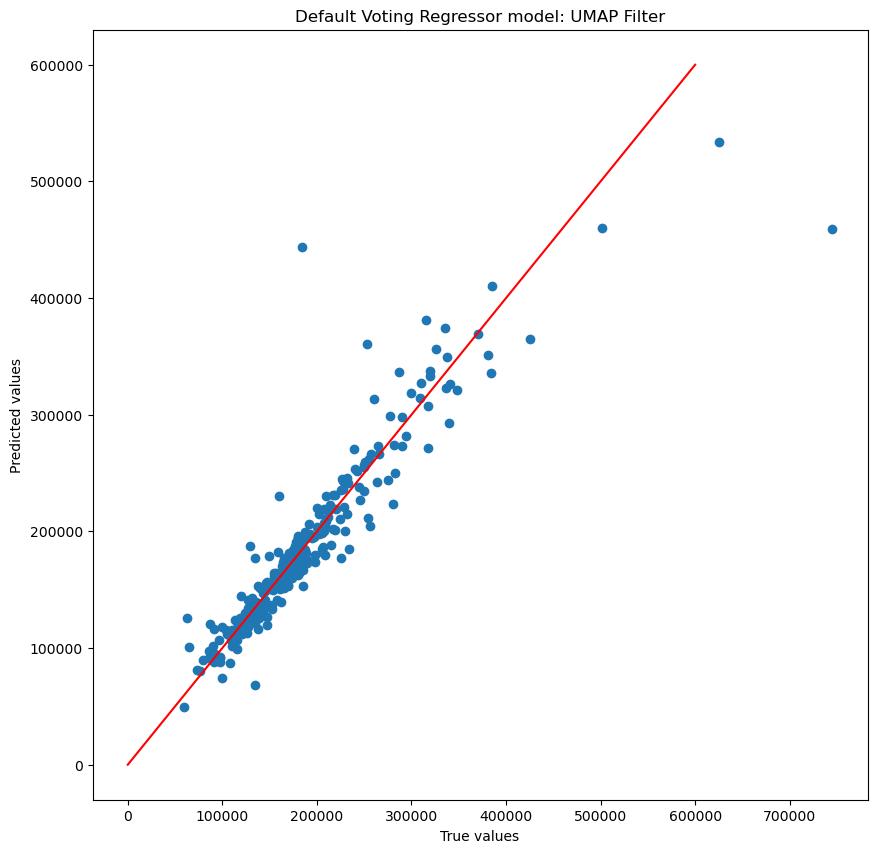

R^2: 0.854
RMSE: 30900.362
MAE: 15349.817
Pearson correlation: 0.924
Spearman correlation: 0.960


In [27]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_UMAP, y_pred_vr)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Default Voting Regressor model: UMAP Filter")
plt.show()

pearson_corr_best_UMAP, _ = stats.pearsonr(y_test_UMAP, y_pred_vr)
spearman_corr_best_UMAP, _ = stats.spearmanr(y_test_UMAP, y_pred_vr)
r2_best_UMAP = r2_score(y_test_UMAP, y_pred_vr)
mae_best_UMAP = mean_absolute_error(y_test_UMAP, y_pred_vr)
rmse_best_UMAP = math.sqrt(mean_squared_error(y_test_UMAP, y_pred_vr))

print(f"R^2: {r2_best_UMAP:.3f}")
print(f"RMSE: {rmse_best_UMAP:.3f}")
print(f"MAE: {mae_best_UMAP:.3f}")
print(f"Pearson correlation: {pearson_corr_best_UMAP:.3f}")
print(f"Spearman correlation: {spearman_corr_best_UMAP:.3f}")

In [28]:
test_file_path = "../Data/Data/Initial Filtering/test_filter.csv"
test_df = pd.read_csv(test_file_path) #(1459, 66)

X_preprocessed_sub = pipeline.transform(test_df) 

y_pred_sub =  vr.predict(X_preprocessed_sub)

In [29]:
submission = test_df[['Id']]
submission['SalePrice'] = y_pred_sub

submission.to_csv("../Data/Data/Submission/submission_vr.csv", index=False)
submission.shape

/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_28888/3792390360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['SalePrice'] = y_pred_sub


(1459, 2)